#1. Introduction
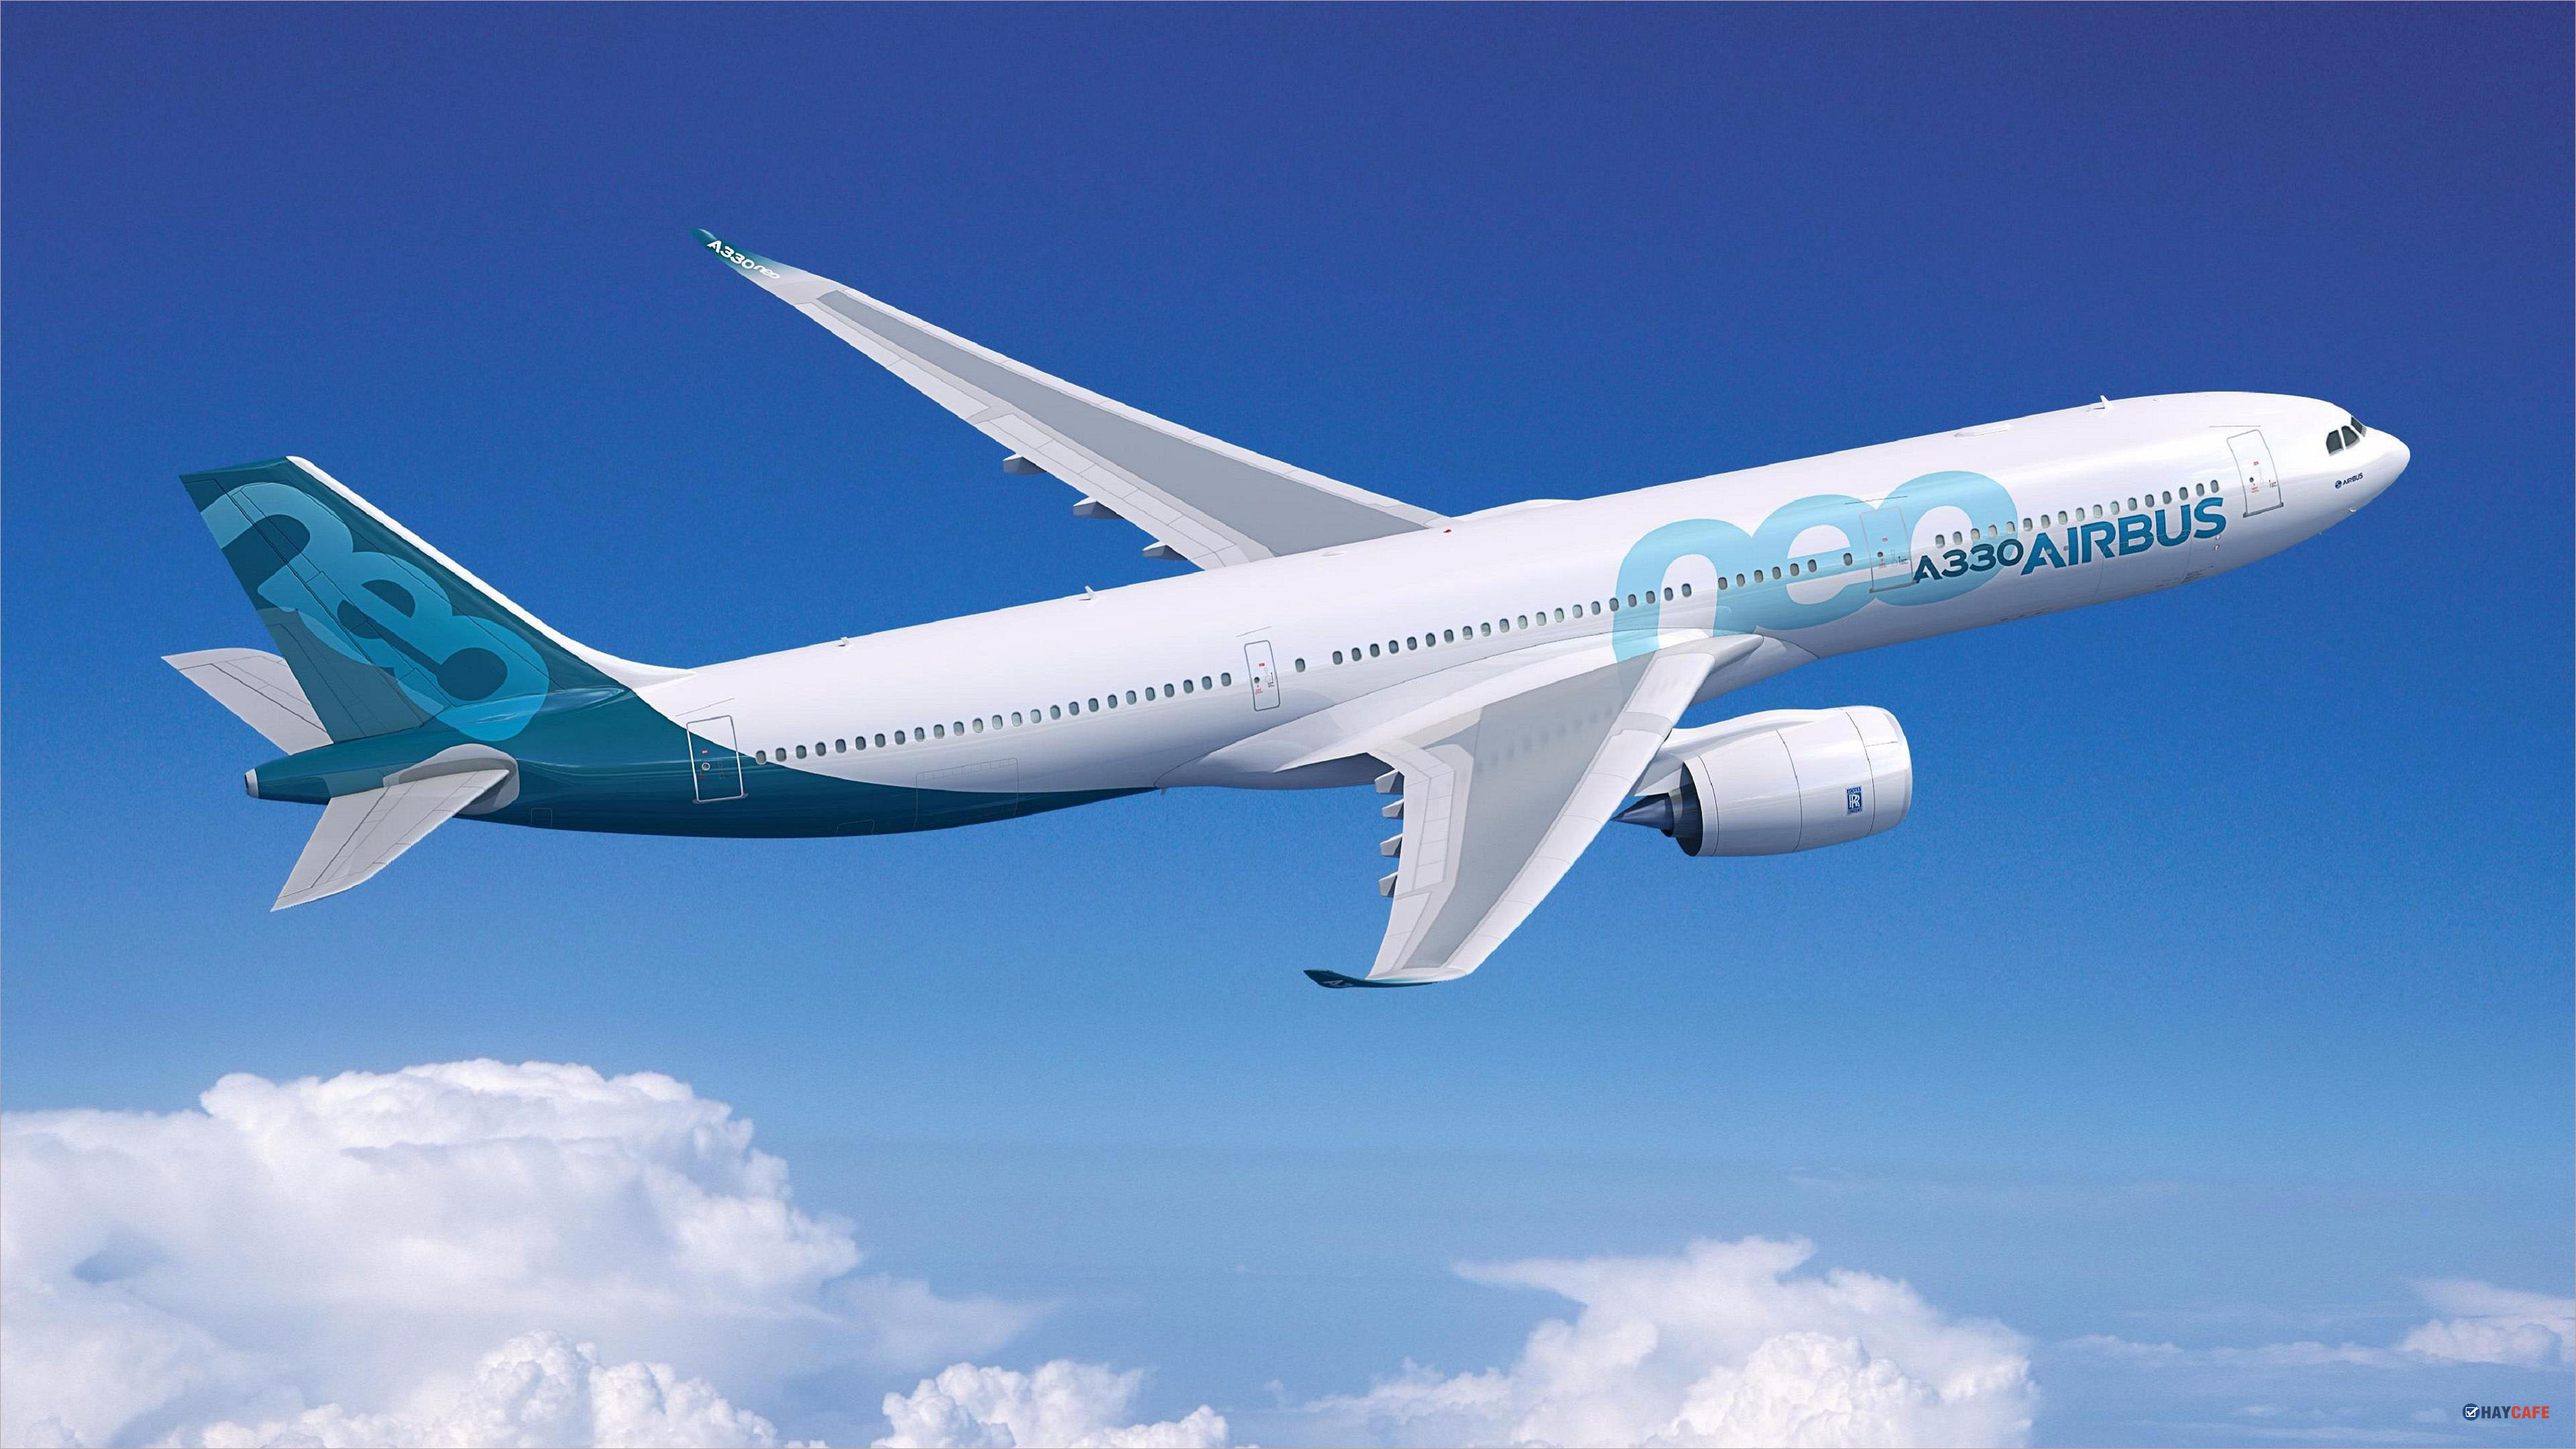

- Tập dữ liệu này cung cấp tổng số hành khách hàng tháng của một hãng hàng không Hoa Kỳ từ năm 1949 đến năm 1960.

- Tập dữ liệu có 2 biến: là Month (Năm-tháng) và biến Passengers (tổng số hành khách theo tháng).

- **Mục tiêu:** Phân tích và dự báo số hành khách tương lai trong 5 năm tiếp theo ( 1961 - 1965). Từ đó giúp hãng hàng không có thể có cái nhìn tổng quan về khả năng kinh doanh trong tương lai, lên kế hoạch cụ thể để phát triển cũng như hạn chế được rủi ro.

#2. Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pywt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#3. Import Data

In [ ]:
data= pd.read_csv('/content/AirPassengers.csv')
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


- Data có 144 dòng dữ liệu, tương ứng 12 tháng của 12 năm.

- Không có giá trị null trong data.

- Cột "Month" không đúng kiểu dữ liệu.

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


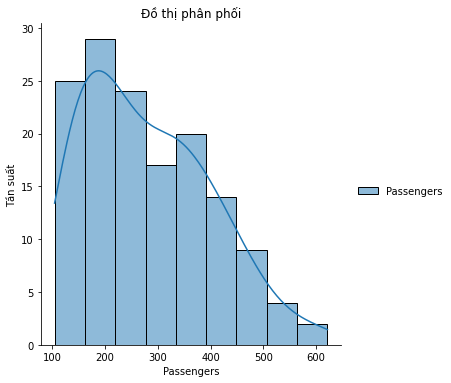

In [ ]:
sns.displot(data, kde=True)
plt.xlabel('Passengers')
plt.ylabel('Tần suất')
plt.title('Đồ thị phân phối')
plt.show()

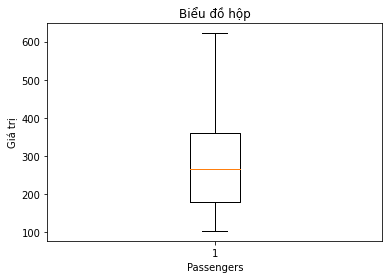

In [ ]:
plt.boxplot(data['Passengers'])
plt.xlabel('Passengers')
plt.ylabel('Giá trị')
plt.title('Biểu đồ hộp')
plt.show()

Nhận xét: 

- Dữ liệu có phân phối lệch phải, 200 là tổng số hành khách mà hãng thường phục vụ.

- Theo biểu đồ hộp, dữ liệu không có giá trị ngoại lệ.

#4. Data Pre-Processing

In [ ]:
#Astype cột "Month" thành kiểu dữ liệu datetime
data['Month']=pd.to_datetime(data['Month']).dt.strftime('%m-%Y')
data['Month']=pd.to_datetime(data['Month'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


#5. EDA

Text(0.5, 1.0, 'Biểu đồ đường')

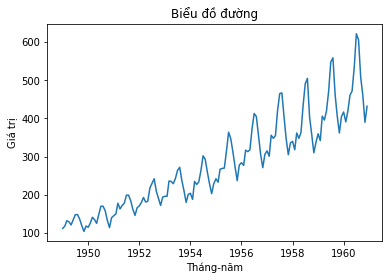

In [ ]:
x=data['Month']
y=data['Passengers']
plt.plot(x, y)
plt.xlabel('Tháng-năm')
plt.ylabel('Giá trị')
plt.title('Biểu đồ đường')

Nhận xét: quan sát đồ thị đường, ta nhận thấy số hành khách theo tháng có xu hướng tăng đều qua các năm. Nhận thấy đồ thị có xu hướng đi lên.

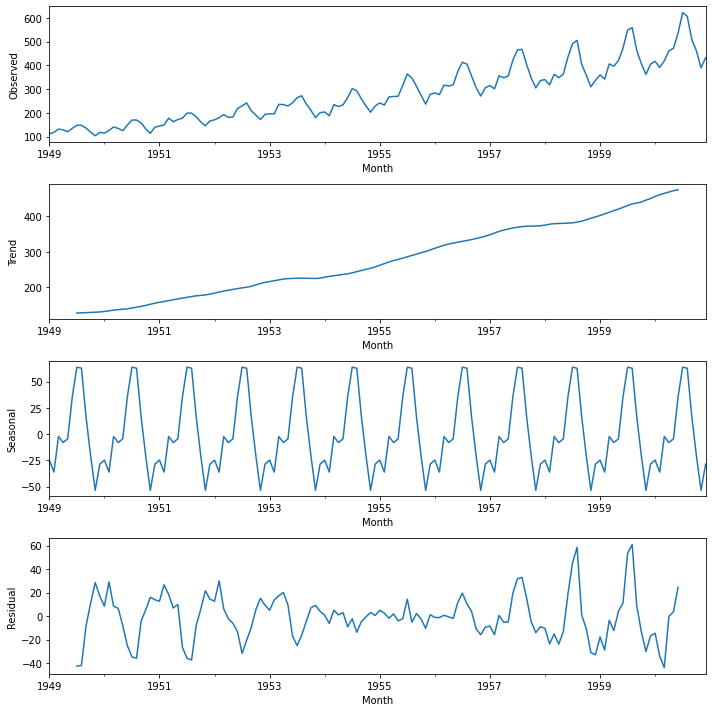

In [ ]:
#Vẽ đồ thị phân rã: phân tích chuỗi thời gian thành các thành phần là trend (xu hướng), seasonality (tính mùa) và residual (phần dư)
data.set_index('Month', inplace=True)
result = seasonal_decompose(data['Passengers'], model='additive')

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,10))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

Nhận xét:

- Trend: Dữ liệu có xu hướng tăng trong khoảng thời gian dài từ năm 1949 - 1960.

- Seasonality: Dữ liệu có tính mùa, cao điểm vào khoảng tháng 5 hằng năm, chạm đáy vào khoảng tháng 10 năm trước và tháng 10 năm đang xét, tính mùa 12 tháng từ tháng 10 năm trước đến tháng 10 năm sau.

- Residual: biến động ngẫu nhiên, có tăng giảm bất thường vào khoảng từ năm 1949 - 1954 và 1957 - 1960. Trong khoảng từ 1955 - 1956 thì hầu như tăng giảm lượng khách không đáng kể.

#6. Statistical Tests

## Augmented Dickey-Fuller (ADF)
- Để xem dữ liệu chuỗi thời gian có tính dừng hay không. Nếu không dừng, nghĩa là có xu hướng thay đổi theo thời gian và không ổn định, dẫn đến việc phân tích và dự báo chuỗi thời gian là không hiệu quả.
- Kiểm định tính dừng của dữ liệu bằng kiểm định Augmented Dickey-Fuller (ADF), với giả thuyết:

H0: Chuỗi dữ liệu không có tính dừng

H1: Chuỗi dữ liệu có tính dừng


In [ ]:
result_ADF= adfuller(data['Passengers'])
result_ADF

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

Nhận xét: 
- Với pvalue = 0.992 >> 0.05, không thể bác bỏ H0. Vậy dữ liệu không có tính dừng. 

- Để dự báo chuỗi thời gian tốt, ta cần khắc phục chuỗi dữ liệu, để nó có tính dừng.

###Khắc phục tính không dừng
- Lấy sai phân cho chuỗi dữ liệu thời gian (loại bỏ tính trend của dữ liệu - nguyên nhân làm dữ liệu không dừng)

####Lấy sai phân bậc 1

In [ ]:
diff_1= data.diff()

In [ ]:
#Do lấy sai phân bậc 1 nên dòng dữ liệu đầu tiên bị bỏ
diff_1= diff_1.drop('1949-01-01')

In [ ]:
#Kiểm định lại ADF sau khi lấy sai phân bậc 1
result_ADF= adfuller(diff_1)
result_ADF

(-2.8292668241700047,
 0.05421329028382478,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854085)

Nhận xét: pvalue = 0.054 > 0.05, không thể bác bỏ H0, nghĩa là dữ liệu không có tính dừng. Tiếp tục lấy sai phân bậc 2.

####Lấy sai phân bậc 2

In [ ]:
diff_2 = diff_1.diff()

In [ ]:
diff_2= diff_2.drop('1949-02-01')

In [ ]:
#Kiểm định lại ADF sau khi lấy sai phân bậc 2
result_ADF= adfuller(diff_2)
result_ADF

(-16.384231542468513,
 2.7328918500142026e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.6020417275611)

Nhận xét; pvalue << 0.05, bác bỏ H0. Vậy dữ liệu có tính dừng sau khi lấy sai phân bậc 2.

##Kiểm định tính nhiễu trắng của dữ liệu (White noise)
- Kiểm định giúp đảm bảo rằng dữ liệu có kỳ vọng bằng 0, phương sai không đổi và thành phần trong chuỗi không tự tương quan. Điều này sẽ cho phép chúng ta áp dụng các mô hình dự báo chuỗi thời gian một cách chính xác.
- Dùng kiểm định Ljung-Box, với:

H0: Dữ liệu không có tính nhiễu trắng

H1: Dữ liệu có tính nhiễu trắng

In [ ]:
p_value = sm.stats.acorr_ljungbox(diff_2,lags=1)
print(p_value)

    lb_stat  lb_pvalue
1  5.290846   0.021438


Nhận xét: pvalue = 0.02 < 0.05, bác bỏ H0, nghĩa là dữ liệu có tính nhiễu trắng. 

***Vậy dữ liệu chuỗi trên đã thỏa mãn 2 kiểm định cần thiết để xây dựng mô hình dự báo chuỗi thời gian.***

#7. Correlation Graph

##Biểu đồ hệ số tự tương quan ACF - Autocorrelation Function
- Bậc q trong mô hình ARIMA (Autoregressive Integrated Moving Average) thể hiện số lượng lags của phần tử MA (Moving Average).
- Trục hoành là độ trễ, trục tung là giá trị của hệ số tự tương quan tương ứng với độ trễ. Với khoảng tin cậy 95% để giá trị hệ số tự tương quan bằng 0.
-	Đồ thị ACF sẽ được sử dụng để xác định bậc q của quá trình MA. Để xác định q, ta căn cứ chọn những độ trễ nằm ngoài mức ý nghĩa 5%.
- Căn cứ đồ ACF ở dưới, ta thấy có các giá trị vượt ngoài khoảng tin cậy là: 1,2,3,4,5,6,7,8,9,10,11,12,13
- Tuy nhiên, thông thường chỉ chọn tối đa là 5, nên sẽ chọn 5 tương quan lớn nhất, q sẽ là: 1, 2, 3, 4, 5


<Figure size 576x432 with 0 Axes>

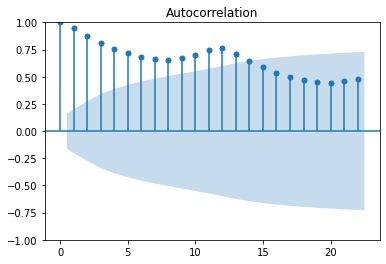

In [ ]:
plt.figure(figsize = (8, 6))
ax1 = plot_acf(data)

##Biểu đồ hệ số tự tương quan riêng phần PACF - Partitial AutoCorrelation Function
-	Về cơ bản tương quan riêng phần cũng là chỉ số đo lường hệ số tương quan như ACF. Tuy nhiên, khác biệt đó là hệ số tương quan này loại bỏ ảnh hưởng của các chuỗi độ trễ trung gian (là các chuỗi trễ xt−1,…,xt−k+1 nằm giữa xt và xt−k).
-	PACF sẽ có tác dụng tìm ra hệ số bậc tự do p của quá trình tự hồi qui AR(p).
-	Dựa vào đỉnh của đồ thị PACF với các mức trễ liên tiếp nhau. Nếu độ trễ có đỉnh nằm ngoài khoảng tin cậy 5% thì giá trị bậc của AR sẽ được quyết định bằng chính những độ trễ này. 
- Căn cứ vào đồ thị PACF ở dưới, các giá trị vượt ngoài khoảng tin cậy là: 1, 2, 9, 10, 11, 13, 15, 18, 20, 22
- Tuy nhiên, thông thường chỉ chọn tối đa là 5, nên sẽ chọn 5 tương quan lớn nhất, p sẽ là: 1, 2, 9, 13, 22

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 576x432 with 0 Axes>

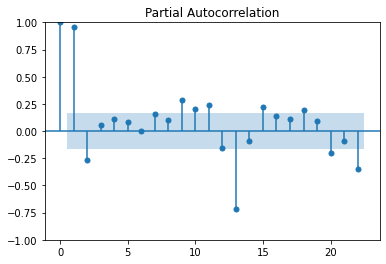

In [ ]:
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(data)

#8. Model building

## Mô hình tự hồi quy AR(p)
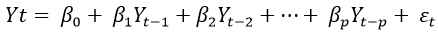
-	Mô hình AR(p) là mô hình hồi quy trên chính số liệu quá khứ ở những chu kì trước.
-	Yt là một hàm tuyến tính của những quan sát dừng quá khứ Yt-1. Yt-2 … Nói cách khác khi sử dụng phân tích hồi quy Yt theo các giá trị chuỗi thời gian dừng có độ trễ, chúng ta sẽ được mô hình AR (yếu tố xu thế đã được tách khỏi yếu tố thời gian, chúng ta sẽ mô hình hóa những yếu tố còn lại – đó là sai số). 
-	Số quan sát dừng quá khứ sử dụng trong mô hình hàm tự tương quan là bậc p của mô hình AR.


###Mô hình AR(1)

In [ ]:
#Xây dựng mô hình
model_AR_1= sm.tsa.ARIMA(data['Passengers'], order=(1,0,0))
model_AR_1=model_AR_1.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -711.090
Date:                Mon, 13 Mar 2023   AIC                           1428.181
Time:                        07:40:45   BIC                           1437.090
Sample:                    01-01-1949   HQIC                          1431.801
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2943     66.403      4.221      0.000     150.146     410.442
ar.L1          0.9645      0.019     51.535      0.000       0.928       1.001
sigma2      1118.5409    122.133      9.158      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
#dự đoán
forecast_AR_1 = model_AR_1.predict()
#Tính giá trị ME
me_AR_1=mean_squared_error(data['Passengers'],forecast_AR_1)
print('ME =',me_AR_1)
#tính giá trị MSE
mae_AR_1=mean_absolute_error(data['Passengers'], forecast_AR_1)
print('MSE =',mae_AR_1)

ME = 1301.6349191218908
MSE = 26.56680927654614


###Mô hình AR(2)

In [ ]:
#Xây dựng mô hình
model_AR_2= sm.tsa.ARIMA(data['Passengers'], order=(2,0,0))
model_AR_2=model_AR_2.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_AR_2.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -702.819
Date:                Mon, 13 Mar 2023   AIC                           1413.639
Time:                        07:40:45   BIC                           1425.518
Sample:                    01-01-1949   HQIC                          1418.466
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2991     54.518      5.141      0.000     173.445     387.153
ar.L1          1.2831      0.079     16.316      0.000       1.129       1.437
ar.L2         -0.3322      0.082     -4.054      0.0

In [ ]:
#dự đoán
forecast_AR_2 = model_AR_2.predict()
#Tính giá trị ME
me_AR_2=mean_squared_error(data['Passengers'],forecast_AR_2)
print('ME =',me_AR_2)
#tính giá trị MSE
mae_AR_2=mean_absolute_error(data['Passengers'], forecast_AR_2)
print('MSE =',mae_AR_2)

ME = 1179.9272282573622
MSE = 25.321037787058234


###Mô hình AR(9)

In [ ]:
#Xây dựng mô hình
model_AR_9= sm.tsa.ARIMA(data['Passengers'], order=(9,0,0))
model_AR_9=model_AR_9.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_AR_9.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(9, 0, 0)   Log Likelihood                -674.035
Date:                Mon, 13 Mar 2023   AIC                           1370.070
Time:                        07:40:48   BIC                           1402.738
Sample:                    01-01-1949   HQIC                          1383.344
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3050    183.059      1.531      0.126     -78.485     639.095
ar.L1          1.2372      0.093     13.344      0.000       1.055       1.419
ar.L2         -0.5626      0.144     -3.918      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_AR_9 = model_AR_9.predict()
#Tính giá trị ME
me_AR_9=mean_squared_error(data['Passengers'],forecast_AR_9)
print('ME =',me_AR_9)
#tính giá trị MSE
mae_AR_9=mean_absolute_error(data['Passengers'], forecast_AR_9)
print('MSE =',mae_AR_9)

ME = 842.9041484820266
MSE = 20.90339710749616


###Mô hình AR(13)

In [ ]:
#Xây dựng mô hình
model_AR_13= sm.tsa.ARIMA(data['Passengers'], order=(13,0,0))
model_AR_13=model_AR_13.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_AR_13.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(13, 0, 0)   Log Likelihood                -572.245
Date:                Mon, 13 Mar 2023   AIC                           1174.491
Time:                        07:40:52   BIC                           1219.038
Sample:                    01-01-1949   HQIC                          1192.592
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3005     99.461      2.818      0.005      85.360     475.241
ar.L1          0.9931      0.057     17.280      0.000       0.880       1.106
ar.L2         -0.0643      0.081     -0.795      0.4

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_AR_13 = model_AR_13.predict()
#Tính giá trị ME
me_AR_13=mean_squared_error(data['Passengers'],forecast_AR_13)
print('ME =',me_AR_13)
#tính giá trị MSE
mae_AR_13=mean_absolute_error(data['Passengers'], forecast_AR_13)
print('MSE =',mae_AR_13)

ME = 338.26177107750294
MSE = 10.229427949635117


###Mô hình AR(22)

In [ ]:
#Xây dựng mô hình
model_AR_22= sm.tsa.ARIMA(data['Passengers'], order=(22,0,0))
model_AR_22=model_AR_22.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_AR_22.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(22, 0, 0)   Log Likelihood                -564.342
Date:                Mon, 13 Mar 2023   AIC                           1176.683
Time:                        07:41:09   BIC                           1247.959
Sample:                    01-01-1949   HQIC                          1205.646
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3003     79.710      3.517      0.000     124.072     436.528
ar.L1          0.6606      0.101      6.511      0.000       0.462       0.859
ar.L2          0.3035      0.171      1.774      0.0

In [ ]:
#dự đoán
forecast_AR_22 = model_AR_22.predict()
#Tính giá trị ME
me_AR_22=mean_squared_error(data['Passengers'],forecast_AR_22)
print('ME =',me_AR_22)
#tính giá trị MSE
mae_AR_22=mean_absolute_error(data['Passengers'], forecast_AR_22)
print('MSE =',mae_AR_22)

ME = 318.04589816175786
MSE = 9.593644639855995


##Mô hình trung bình trượt MA(q)
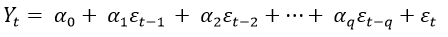
- Quan sát dừng hiện tại Yt là một hàm tuyến tính phụ thuộc các biến sai số dự báo quá khứ và hiện tại. 

###Mô hình MA(1)

In [ ]:
#Xây dựng mô hình
model_MA_1= sm.tsa.ARIMA(data['Passengers'], order=(0,0,1))
model_MA_1=model_MA_1.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_MA_1.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -806.431
Date:                Mon, 13 Mar 2023   AIC                           1618.863
Time:                        07:41:10   BIC                           1627.772
Sample:                    01-01-1949   HQIC                          1622.483
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.6501     11.649     24.092      0.000     257.818     303.482
ma.L1          0.9642      0.030     32.217      0.000       0.906       1.023
sigma2      4205.2248    586.724      7.167      0.0

In [ ]:
#dự đoán
forecast_MA_1 = model_MA_1.predict()
#Tính giá trị ME
me_MA_1=mean_squared_error(data['Passengers'],forecast_MA_1)
print('ME =',me_MA_1)
#tính giá trị MSE
mae_MA_1=mean_absolute_error(data['Passengers'], forecast_MA_1)
print('MSE =',mae_MA_1)

ME = 4382.3621709421295
MSE = 53.71714968294322


###Mô hình MA(2)

In [ ]:
#Xây dựng mô hình
model_MA_2= sm.tsa.ARIMA(data['Passengers'], order=(0,0,2))
model_MA_2=model_MA_2.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_MA_2.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -757.063
Date:                Mon, 13 Mar 2023   AIC                           1522.126
Time:                        07:41:11   BIC                           1534.005
Sample:                    01-01-1949   HQIC                          1526.953
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.4095     14.386     19.491      0.000     252.213     308.606
ma.L1          1.3825     23.075      0.060      0.952     -43.844      46.609
ma.L2          1.0000     33.380      0.030      0.9

In [ ]:
#dự đoán
forecast_MA_2 = model_MA_2.predict()
#Tính giá trị ME
me_MA_2=mean_squared_error(data['Passengers'],forecast_MA_2)
print('ME =',me_MA_2)
#tính giá trị MSE
mae_MA_2=mean_absolute_error(data['Passengers'], forecast_MA_2)
print('MSE =',mae_MA_2)

ME = 2275.9219989304265
MSE = 38.290724774097335


###Mô hình MA(3)

In [ ]:
#Xây dựng mô hình
model_MA_3= sm.tsa.ARIMA(data['Passengers'], order=(0,0,3))
model_MA_3=model_MA_3.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_MA_3.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -725.681
Date:                Mon, 13 Mar 2023   AIC                           1461.362
Time:                        07:41:12   BIC                           1476.211
Sample:                    01-01-1949   HQIC                          1467.396
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2934     16.609     16.876      0.000     247.741     312.846
ma.L1          1.4274    121.623      0.012      0.991    -236.949     239.804
ma.L2          1.4272     52.337      0.027      0.9

In [ ]:
#dự đoán
forecast_MA_3 = model_MA_3.predict()
#Tính giá trị ME
me_MA_3=mean_squared_error(data['Passengers'],forecast_MA_3)
print('ME =',me_MA_3)
#tính giá trị MSE
mae_MA_3=mean_absolute_error(data['Passengers'], forecast_MA_3)
print('MSE =',mae_MA_3)

ME = 1523.2143029632564
MSE = 29.41382095235669


###Mô hình MA(4)

In [ ]:
#Xây dựng mô hình
model_MA_4= sm.tsa.ARIMA(data['Passengers'], order=(0,0,4))
model_MA_4=model_MA_4.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_MA_4.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 4)   Log Likelihood                -721.731
Date:                Mon, 13 Mar 2023   AIC                           1455.462
Time:                        07:41:15   BIC                           1473.281
Sample:                    01-01-1949   HQIC                          1462.703
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3106     19.601     14.301      0.000     241.892     318.729
ma.L1          1.6129      0.203      7.963      0.000       1.216       2.010
ma.L2          1.6961      1.133      1.497      0.1

In [ ]:
#dự đoán
forecast_MA_4 = model_MA_4.predict()
#Tính giá trị ME
me_MA_4=mean_squared_error(data['Passengers'],forecast_MA_4)
print('ME =',me_MA_4)
#tính giá trị MSE
mae_MA_4=mean_absolute_error(data['Passengers'], forecast_MA_4)
print('MSE =',mae_MA_4)

ME = 1446.4481642088695
MSE = 28.525660988755803


###Mô hình MA(5)

In [ ]:
#Xây dựng mô hình
model_MA_5= sm.tsa.ARIMA(data['Passengers'], order=(0,0,5))
model_MA_5=model_MA_5.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_MA_5.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 5)   Log Likelihood                -733.783
Date:                Mon, 13 Mar 2023   AIC                           1481.565
Time:                        07:41:18   BIC                           1502.354
Sample:                    01-01-1949   HQIC                          1490.013
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3150     16.333     17.163      0.000     248.303     312.327
ma.L1          1.1215     79.140      0.014      0.989    -153.990     156.233
ma.L2          0.3924      9.686      0.041      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_MA_5 = model_MA_5.predict()
#Tính giá trị ME
me_MA_5=mean_squared_error(data['Passengers'],forecast_MA_5)
print('ME =',me_MA_5)
#tính giá trị MSE
mae_MA_5=mean_absolute_error(data['Passengers'], forecast_MA_5)
print('MSE =',mae_MA_5)

ME = 1667.427105025588
MSE = 31.331656652426123


##Mô hình tự hồi quy kết hợp với trung bình trượt ARIMA(p,d,q)
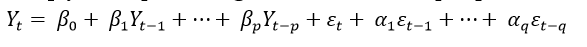
- Vì lấy sai phân bậc 2, nên d=2.
- Là mô hình hỗn hợp của AR và MA. Hàm tuyến tính sẽ bao gồm những quan sát dừng quá khứ và những sai số dự báo quá khứ và hiện tại.

###Mô hình ARIMA(1,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_1= sm.tsa.ARIMA(data['Passengers'], order=(1,2,1))
model_ARIMA_1=model_ARIMA_1.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_1.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -696.464
Date:                Mon, 13 Mar 2023   AIC                           1398.928
Time:                        07:41:19   BIC                           1407.796
Sample:                    01-01-1949   HQIC                          1402.532
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3130      0.100      3.127      0.002       0.117       0.509
ma.L1         -0.9998      5.894     -0.170      0.865     -12.551      10.552
sigma2      1034.0009   6133.239      0.169      0.8

In [ ]:
#dự đoán
forecast_ARIMA_1 = model_ARIMA_1.predict()
#Tính giá trị ME
me_ARIMA_1=mean_squared_error(data['Passengers'],forecast_ARIMA_1)
print('ME =',me_ARIMA_1)
#tính giá trị MSE
mae_ARIMA_1=mean_absolute_error(data['Passengers'], forecast_ARIMA_1)
print('MSE =',mae_ARIMA_1)

ME = 1137.2774549725723
MSE = 26.11534511729693


###Mô hình ARIMA(1,2,2)

In [ ]:
#Xây dựng mô hình
model_ARIMA_2= sm.tsa.ARIMA(data['Passengers'], order=(1,2,2))
model_ARIMA_2=model_ARIMA_2.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_2.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -691.954
Date:                Mon, 13 Mar 2023   AIC                           1391.908
Time:                        07:41:20   BIC                           1403.732
Sample:                    01-01-1949   HQIC                          1396.713
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4710      0.123     -3.838      0.000      -0.711      -0.230
ma.L1         -0.1369     18.236     -0.008      0.994     -35.879      35.605
ma.L2         -0.8631     15.736     -0.055      0.9

In [ ]:
#dự đoán
forecast_ARIMA_2 = model_ARIMA_2.predict()
#Tính giá trị ME
me_ARIMA_2=mean_squared_error(data['Passengers'],forecast_ARIMA_2)
print('ME =',me_ARIMA_2)
#tính giá trị MSE
mae_ARIMA_2=mean_absolute_error(data['Passengers'], forecast_ARIMA_2)
print('MSE =',mae_ARIMA_2)

ME = 1069.405249019583
MSE = 25.503996396918176


###Mô hình ARIMA(1,2,3)

In [ ]:
#Xây dựng mô hình
model_ARIMA_3= sm.tsa.ARIMA(data['Passengers'], order=(1,2,3))
model_ARIMA_3=model_ARIMA_3.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_3.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -691.234
Date:                Mon, 13 Mar 2023   AIC                           1392.468
Time:                        07:41:22   BIC                           1407.247
Sample:                    01-01-1949   HQIC                          1398.473
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6779      0.226     -2.993      0.003      -1.122      -0.234
ma.L1          0.1087     21.516      0.005      0.996     -42.062      42.279
ma.L2         -0.9211     24.038     -0.038      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_3 = model_ARIMA_3.predict()
#Tính giá trị ME
me_ARIMA_3=mean_squared_error(data['Passengers'],forecast_ARIMA_3)
print('ME =',me_ARIMA_3)
#tính giá trị MSE
mae_ARIMA_3=mean_absolute_error(data['Passengers'], forecast_ARIMA_3)
print('MSE =',mae_ARIMA_3)

ME = 1060.7812064736145
MSE = 25.45563947776439


###Mô hình ARIMA(1,2,4)

In [ ]:
#Xây dựng mô hình
model_ARIMA_4= sm.tsa.ARIMA(data['Passengers'], order=(1,2,4))
model_ARIMA_4=model_ARIMA_4.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_4.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 4)   Log Likelihood                -691.109
Date:                Mon, 13 Mar 2023   AIC                           1394.218
Time:                        07:41:24   BIC                           1411.953
Sample:                    01-01-1949   HQIC                          1401.425
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6408      0.259     -2.473      0.013      -1.149      -0.133
ma.L1          0.0993     15.679      0.006      0.995     -30.631      30.830
ma.L2         -0.8430     17.173     -0.049      0.9

In [ ]:
#dự đoán
forecast_ARIMA_4 = model_ARIMA_4.predict()
#Tính giá trị ME
me_ARIMA_4=mean_squared_error(data['Passengers'],forecast_ARIMA_4)
print('ME =',me_ARIMA_4)
#tính giá trị MSE
mae_ARIMA_4=mean_absolute_error(data['Passengers'], forecast_ARIMA_4)
print('MSE =',mae_ARIMA_4)

ME = 1059.9641145503829
MSE = 25.44091744115441


###Mô hình ARIMA(1,2,5)

In [ ]:
#Xây dựng mô hình
model_ARIMA_5= sm.tsa.ARIMA(data['Passengers'], order=(1,2,5))
model_ARIMA_5=model_ARIMA_5.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_5.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 5)   Log Likelihood                -676.033
Date:                Mon, 13 Mar 2023   AIC                           1366.067
Time:                        07:41:27   BIC                           1386.757
Sample:                    01-01-1949   HQIC                          1374.475
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2922      0.136     -2.145      0.032      -0.559      -0.025
ma.L1         -0.5365      2.446     -0.219      0.826      -5.331       4.258
ma.L2         -0.5392      3.509     -0.154      0.8

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_5 = model_ARIMA_5.predict()
#Tính giá trị ME
me_ARIMA_5=mean_squared_error(data['Passengers'],forecast_ARIMA_5)
print('ME =',me_ARIMA_5)
#tính giá trị MSE
mae_ARIMA_5=mean_absolute_error(data['Passengers'], forecast_ARIMA_5)
print('MSE =',mae_ARIMA_5)

ME = 838.7746670246165
MSE = 20.784703961192943


###Mô hình ARIMA(2,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_6= sm.tsa.ARIMA(data['Passengers'], order=(2,2,1))
model_ARIMA_6=model_ARIMA_6.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_6.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -692.943
Date:                Mon, 13 Mar 2023   AIC                           1393.887
Time:                        07:41:27   BIC                           1405.710
Sample:                    01-01-1949   HQIC                          1398.691
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3845      0.092      4.194      0.000       0.205       0.564
ar.L2         -0.2259      0.071     -3.181      0.001      -0.365      -0.087
ma.L1         -0.9987      0.676     -1.478      0.1

In [ ]:
#dự đoán
forecast_ARIMA_6 = model_ARIMA_6.predict()
#Tính giá trị ME
me_ARIMA_6=mean_squared_error(data['Passengers'],forecast_ARIMA_6)
print('ME =',me_ARIMA_6)
#tính giá trị MSE
mae_ARIMA_6=mean_absolute_error(data['Passengers'], forecast_ARIMA_6)
print('MSE =',mae_ARIMA_6)

ME = 1084.4152795670416
MSE = 25.931786824317587


###Mô hình ARIMA(2,2,2)

In [ ]:
#Xây dựng mô hình
model_ARIMA_7= sm.tsa.ARIMA(data['Passengers'], order=(2,2,2))
model_ARIMA_7=model_ARIMA_7.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_7.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -691.328
Date:                Mon, 13 Mar 2023   AIC                           1392.657
Time:                        07:41:30   BIC                           1407.436
Sample:                    01-01-1949   HQIC                          1398.663
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4633      0.122     -3.785      0.000      -0.703      -0.223
ar.L2          0.1066      0.116      0.918      0.359      -0.121       0.334
ma.L1         -0.1056     19.656     -0.005      0.9

In [ ]:
#dự đoán
forecast_ARIMA_7 = model_ARIMA_7.predict()
#Tính giá trị ME
me_ARIMA_7=mean_squared_error(data['Passengers'],forecast_ARIMA_7)
print('ME =',me_ARIMA_7)
#tính giá trị MSE
mae_ARIMA_7=mean_absolute_error(data['Passengers'], forecast_ARIMA_7)
print('MSE =',mae_ARIMA_7)

ME = 1062.230757293505
MSE = 25.43529970938522


###Mô hình ARIMA(2,2,3)

In [ ]:
#Xây dựng mô hình
model_ARIMA_8= sm.tsa.ARIMA(data['Passengers'], order=(2,2,3))
model_ARIMA_8=model_ARIMA_8.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_8.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -691.215
Date:                Mon, 13 Mar 2023   AIC                           1394.430
Time:                        07:41:32   BIC                           1412.165
Sample:                    01-01-1949   HQIC                          1401.637
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6179      0.803     -0.769      0.442      -2.192       0.956
ar.L2          0.0380      0.408      0.093      0.926      -0.762       0.838
ma.L1          0.0538     11.442      0.005      0.9

In [ ]:
#dự đoán
forecast_ARIMA_8 = model_ARIMA_8.predict()
#Tính giá trị ME
me_ARIMA_8=mean_squared_error(data['Passengers'],forecast_ARIMA_8)
print('ME =',me_ARIMA_8)
#tính giá trị MSE
mae_ARIMA_8=mean_absolute_error(data['Passengers'], forecast_ARIMA_8)
print('MSE =',mae_ARIMA_8)

ME = 1060.6864532809045
MSE = 25.453043842449492


###Mô hình ARIMA(2,2,4)

In [ ]:
#Xây dựng mô hình
model_ARIMA_9= sm.tsa.ARIMA(data['Passengers'], order=(2,2,4))
model_ARIMA_9=model_ARIMA_9.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_9.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 2, 4)   Log Likelihood                -678.591
Date:                Mon, 13 Mar 2023   AIC                           1371.183
Time:                        07:41:34   BIC                           1391.874
Sample:                    01-01-1949   HQIC                          1379.591
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7203      0.019    -90.217      0.000      -1.758      -1.683
ar.L2         -0.9933      0.022    -44.742      0.000      -1.037      -0.950
ma.L1          1.3939      0.514      2.714      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_9 = model_ARIMA_9.predict()
#Tính giá trị ME
me_ARIMA_9=mean_squared_error(data['Passengers'],forecast_ARIMA_9)
print('ME =',me_ARIMA_9)
#tính giá trị MSE
mae_ARIMA_9=mean_absolute_error(data['Passengers'], forecast_ARIMA_9)
print('MSE =',mae_ARIMA_9)

ME = 890.4980804725718
MSE = 22.742753586474624


###Mô hình ARIMA(2,2,5)

In [ ]:
#Xây dựng mô hình
model_ARIMA_10= sm.tsa.ARIMA(data['Passengers'], order=(2,2,5))
model_ARIMA_10=model_ARIMA_10.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_10.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 2, 5)   Log Likelihood                -673.805
Date:                Mon, 13 Mar 2023   AIC                           1363.611
Time:                        07:41:37   BIC                           1387.258
Sample:                    01-01-1949   HQIC                          1373.220
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2819      0.095     -2.967      0.003      -0.468      -0.096
ar.L2         -0.2259      0.082     -2.760      0.006      -0.386      -0.065
ma.L1         -0.5507      0.088     -6.247      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_10 = model_ARIMA_10.predict()
#Tính giá trị ME
me_ARIMA_10=mean_squared_error(data['Passengers'],forecast_ARIMA_10)
print('ME =',me_ARIMA_10)
#tính giá trị MSE
mae_ARIMA_10=mean_absolute_error(data['Passengers'], forecast_ARIMA_10)
print('MSE =',mae_ARIMA_10)

ME = 808.7067788414066
MSE = 20.399097028905317


###Mô hình ARIMA(9,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_11= sm.tsa.ARIMA(data['Passengers'], order=(9,2,1))
model_ARIMA_11=model_ARIMA_11.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_11.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(9, 2, 1)   Log Likelihood                -657.775
Date:                Mon, 13 Mar 2023   AIC                           1337.550
Time:                        07:41:39   BIC                           1370.064
Sample:                    01-01-1949   HQIC                          1350.763
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0718      0.102      0.703      0.482      -0.128       0.272
ar.L2         -0.3319      0.072     -4.603      0.000      -0.473      -0.191
ar.L3         -0.1815      0.077     -2.367      0.0

In [ ]:
#dự đoán
forecast_ARIMA_11= model_ARIMA_11.predict()
#Tính giá trị ME
me_ARIMA_11=mean_squared_error(data['Passengers'],forecast_ARIMA_11)
print('ME =',me_ARIMA_11)
#tính giá trị MSE
mae_ARIMA_11=mean_absolute_error(data['Passengers'], forecast_ARIMA_11)
print('MSE =',mae_ARIMA_11)

ME = 680.4217209318867
MSE = 20.46648412140287


###Mô hình ARIMA(9,2,2)

In [ ]:
#Xây dựng mô hình
model_ARIMA_12= sm.tsa.ARIMA(data['Passengers'], order=(9,2,2))
model_ARIMA_12=model_ARIMA_12.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_12.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(9, 2, 2)   Log Likelihood                -661.836
Date:                Mon, 13 Mar 2023   AIC                           1347.673
Time:                        07:41:43   BIC                           1383.143
Sample:                    01-01-1949   HQIC                          1362.086
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7833      0.135     -5.815      0.000      -1.047      -0.519
ar.L2         -0.1344      0.111     -1.210      0.226      -0.352       0.083
ar.L3         -0.4423      0.085     -5.220      0.0

In [ ]:
#dự đoán
forecast_ARIMA_12= model_ARIMA_12.predict()
#Tính giá trị ME
me_ARIMA_12=mean_squared_error(data['Passengers'],forecast_ARIMA_12)
print('ME =',me_ARIMA_12)
#tính giá trị MSE
mae_ARIMA_12=mean_absolute_error(data['Passengers'], forecast_ARIMA_12)
print('MSE =',mae_ARIMA_12)

ME = 717.5373926337162
MSE = 21.16673166290692


###Mô hình ARIMA(9,2,3)

In [ ]:
#Xây dựng mô hình
model_ARIMA_13= sm.tsa.ARIMA(data['Passengers'], order=(9,2,3))
model_ARIMA_13=model_ARIMA_13.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_13.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(9, 2, 3)   Log Likelihood                -642.481
Date:                Mon, 13 Mar 2023   AIC                           1310.962
Time:                        07:41:48   BIC                           1349.388
Sample:                    01-01-1949   HQIC                          1326.577
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4244      1.624     -0.261      0.794      -3.608       2.759
ar.L2          0.1197      0.942      0.127      0.899      -1.726       1.965
ar.L3         -0.4523      0.724     -0.625      0.5

In [ ]:
#dự đoán
forecast_ARIMA_13= model_ARIMA_13.predict()
#Tính giá trị ME
me_ARIMA_13=mean_squared_error(data['Passengers'],forecast_ARIMA_13)
print('ME =',me_ARIMA_13)
#tính giá trị MSE
mae_ARIMA_13=mean_absolute_error(data['Passengers'], forecast_ARIMA_13)
print('MSE =',mae_ARIMA_13)

ME = 559.098629587048
MSE = 17.883532160533218


###Mô hình ARIMA(9,2,4)

In [ ]:
#Xây dựng mô hình
model_ARIMA_14= sm.tsa.ARIMA(data['Passengers'], order=(9,2,4))
model_ARIMA_14=model_ARIMA_14.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_14.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(9, 2, 4)   Log Likelihood                -644.216
Date:                Mon, 13 Mar 2023   AIC                           1316.432
Time:                        07:41:51   BIC                           1357.814
Sample:                    01-01-1949   HQIC                          1333.248
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3984      0.089     -4.484      0.000      -0.572      -0.224
ar.L2         -0.1277      0.081     -1.578      0.115      -0.286       0.031
ar.L3          0.0847      0.075      1.130      0.2

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_14= model_ARIMA_14.predict()
#Tính giá trị ME
me_ARIMA_14=mean_squared_error(data['Passengers'],forecast_ARIMA_14)
print('ME =',me_ARIMA_14)
#tính giá trị MSE
mae_ARIMA_14=mean_absolute_error(data['Passengers'], forecast_ARIMA_14)
print('MSE =',mae_ARIMA_14)

ME = 552.6209572645993
MSE = 17.312710562108606


###Mô hình ARIMA(9,2,5)

In [ ]:
#Xây dựng mô hình
model_ARIMA_15= sm.tsa.ARIMA(data['Passengers'], order=(9,2,5))
model_ARIMA_15=model_ARIMA_15.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_15.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(9, 2, 5)   Log Likelihood                -637.659
Date:                Mon, 13 Mar 2023   AIC                           1305.318
Time:                        07:41:53   BIC                           1349.656
Sample:                    01-01-1949   HQIC                          1323.335
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7238      1.247     -0.581      0.561      -3.167       1.719
ar.L2         -0.3035      0.314     -0.967      0.334      -0.919       0.312
ar.L3          0.0344      0.296      0.116      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_15= model_ARIMA_15.predict()
#Tính giá trị ME
me_ARIMA_15=mean_squared_error(data['Passengers'],forecast_ARIMA_15)
print('ME =',me_ARIMA_15)
#tính giá trị MSE
mae_ARIMA_15=mean_absolute_error(data['Passengers'], forecast_ARIMA_15)
print('MSE =',mae_ARIMA_15)

ME = 526.9154255015047
MSE = 17.081448950142175


###Mô hình ARIMA(13,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_16= sm.tsa.ARIMA(data['Passengers'], order=(13,2,1))
model_ARIMA_16=model_ARIMA_16.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_16.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(13, 2, 1)   Log Likelihood                -554.419
Date:                Mon, 13 Mar 2023   AIC                           1138.839
Time:                        07:41:57   BIC                           1183.176
Sample:                    01-01-1949   HQIC                          1156.856
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3203      0.123     -2.610      0.009      -0.561      -0.080
ar.L2         -0.2349      0.114     -2.067      0.039      -0.458      -0.012
ar.L3         -0.1541      0.139     -1.111      0.2

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_16= model_ARIMA_16.predict()
#Tính giá trị ME
me_ARIMA_16=mean_squared_error(data['Passengers'],forecast_ARIMA_16)
print('ME =',me_ARIMA_16)
#tính giá trị MSE
mae_ARIMA_16=mean_absolute_error(data['Passengers'], forecast_ARIMA_16)
print('MSE =',mae_ARIMA_16)

ME = 231.27849427560835
MSE = 9.89610944519397


###Mô hình ARIMA(13,2,2)

In [ ]:
#Xây dựng mô hình
model_ARIMA_17= sm.tsa.ARIMA(data['Passengers'], order=(13,2,2))
model_ARIMA_17=model_ARIMA_17.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_17.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(13, 2, 2)   Log Likelihood                -557.654
Date:                Mon, 13 Mar 2023   AIC                           1147.308
Time:                        07:41:59   BIC                           1194.601
Sample:                    01-01-1949   HQIC                          1166.526
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6669      0.394     -1.692      0.091      -1.439       0.105
ar.L2         -0.0474      0.552     -0.086      0.932      -1.130       1.035
ar.L3         -0.0090      0.534     -0.017      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_17= model_ARIMA_17.predict()
#Tính giá trị ME
me_ARIMA_17=mean_squared_error(data['Passengers'],forecast_ARIMA_17)
print('ME =',me_ARIMA_17)
#tính giá trị MSE
mae_ARIMA_17=mean_absolute_error(data['Passengers'], forecast_ARIMA_17)
print('MSE =',mae_ARIMA_17)

ME = 238.74942125378362
MSE = 10.111651102163316


###Mô hình ARIMA(13,2,3)

In [ ]:
#Xây dựng mô hình
model_ARIMA_18= sm.tsa.ARIMA(data['Passengers'], order=(13,2,3))
model_ARIMA_18=model_ARIMA_18.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_18.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(13, 2, 3)   Log Likelihood                -555.952
Date:                Mon, 13 Mar 2023   AIC                           1145.903
Time:                        07:42:02   BIC                           1196.152
Sample:                    01-01-1949   HQIC                          1166.322
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7717      2.870     -0.269      0.788      -6.397       4.854
ar.L2         -0.0219      5.092     -0.004      0.997     -10.002       9.958
ar.L3         -0.0312      5.055     -0.006      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_18= model_ARIMA_18.predict()
#Tính giá trị ME
me_ARIMA_18=mean_squared_error(data['Passengers'],forecast_ARIMA_18)
print('ME =',me_ARIMA_18)
#tính giá trị MSE
mae_ARIMA_18=mean_absolute_error(data['Passengers'], forecast_ARIMA_18)
print('MSE =',mae_ARIMA_18)

ME = 233.44257238065074
MSE = 9.963152587220874


###Mô hình ARIMA(13,2,4)

In [ ]:
#Xây dựng mô hình
model_ARIMA_19= sm.tsa.ARIMA(data['Passengers'], order=(13,2,4))
model_ARIMA_19=model_ARIMA_19.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_19.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(13, 2, 4)   Log Likelihood                -556.918
Date:                Mon, 13 Mar 2023   AIC                           1149.837
Time:                        07:42:04   BIC                           1203.042
Sample:                    01-01-1949   HQIC                          1171.457
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7760      1.093     -0.710      0.478      -2.918       1.366
ar.L2         -0.0178      1.951     -0.009      0.993      -3.842       3.807
ar.L3         -0.0566      1.906     -0.030      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_19= model_ARIMA_19.predict()
#Tính giá trị ME
me_ARIMA_19=mean_squared_error(data['Passengers'],forecast_ARIMA_19)
print('ME =',me_ARIMA_19)
#tính giá trị MSE
mae_ARIMA_19=mean_absolute_error(data['Passengers'], forecast_ARIMA_19)
print('MSE =',mae_ARIMA_19)

ME = 233.98899500777492
MSE = 10.048330059768846


###Mô hình ARIMA(13,2,5)

In [ ]:
#Xây dựng mô hình
model_ARIMA_20= sm.tsa.ARIMA(data['Passengers'], order=(13,2,5))
model_ARIMA_20=model_ARIMA_20.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_20.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(13, 2, 5)   Log Likelihood                -551.981
Date:                Mon, 13 Mar 2023   AIC                           1141.962
Time:                        07:42:06   BIC                           1198.122
Sample:                    01-01-1949   HQIC                          1164.783
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8984      0.496     -1.812      0.070      -1.870       0.074
ar.L2         -0.4291      0.406     -1.056      0.291      -1.225       0.367
ar.L3         -0.4151      0.444     -0.935      0.3

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_20= model_ARIMA_20.predict()
#Tính giá trị ME
me_ARIMA_20=mean_squared_error(data['Passengers'],forecast_ARIMA_20)
print('ME =',me_ARIMA_20)
#tính giá trị MSE
mae_ARIMA_20=mean_absolute_error(data['Passengers'], forecast_ARIMA_20)
print('MSE =',mae_ARIMA_20)

ME = 226.09244928617474
MSE = 9.569580624508639


###Mô hình ARIMA(22,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_21= sm.tsa.ARIMA(data['Passengers'], order=(22,2,1))
model_ARIMA_21=model_ARIMA_21.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_21.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(22, 2, 1)   Log Likelihood                -551.554
Date:                Mon, 13 Mar 2023   AIC                           1151.107
Time:                        07:42:13   BIC                           1222.047
Sample:                    01-01-1949   HQIC                          1179.934
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2337      0.121     -1.931      0.054      -0.471       0.004
ar.L2         -0.0529      0.122     -0.434      0.664      -0.292       0.186
ar.L3         -0.0587      0.124     -0.472      0.6

In [ ]:
#dự đoán
forecast_ARIMA_21= model_ARIMA_21.predict()
#Tính giá trị ME
me_ARIMA_21=mean_squared_error(data['Passengers'],forecast_ARIMA_21)
print('ME =',me_ARIMA_21)
#tính giá trị MSE
mae_ARIMA_21=mean_absolute_error(data['Passengers'], forecast_ARIMA_21)
print('MSE =',mae_ARIMA_21)

ME = 226.54363635726085
MSE = 9.65102676311499


###Mô hình ARIMA(22,2,2)

In [ ]:
#Xây dựng mô hình
model_ARIMA_22= sm.tsa.ARIMA(data['Passengers'], order=(22,2,2))
model_ARIMA_22=model_ARIMA_22.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_22.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(22, 2, 2)   Log Likelihood                -554.356
Date:                Mon, 13 Mar 2023   AIC                           1158.713
Time:                        07:42:18   BIC                           1232.608
Sample:                    01-01-1949   HQIC                          1188.741
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7293      0.902     -0.808      0.419      -2.497       1.039
ar.L2         -0.1396      0.258     -0.541      0.589      -0.645       0.366
ar.L3         -0.1001      0.175     -0.571      0.5

In [ ]:
#dự đoán
forecast_ARIMA_22= model_ARIMA_22.predict()
#Tính giá trị ME
me_ARIMA_22=mean_squared_error(data['Passengers'],forecast_ARIMA_22)
print('ME =',me_ARIMA_22)
#tính giá trị MSE
mae_ARIMA_22=mean_absolute_error(data['Passengers'], forecast_ARIMA_22)
print('MSE =',mae_ARIMA_22)

ME = 228.54246958194932
MSE = 9.660717563432037


###Mô hình ARIMA(22,2,3)

In [ ]:
#Xây dựng mô hình
model_ARIMA_23= sm.tsa.ARIMA(data['Passengers'], order=(22,2,3))
model_ARIMA_23=model_ARIMA_23.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_23.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(22, 2, 3)   Log Likelihood                -554.705
Date:                Mon, 13 Mar 2023   AIC                           1161.409
Time:                        07:42:25   BIC                           1238.261
Sample:                    01-01-1949   HQIC                          1192.639
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7430      0.798     -0.931      0.352      -2.307       0.821
ar.L2         -0.2548      0.710     -0.359      0.720      -1.646       1.136
ar.L3         -0.1042      0.222     -0.469      0.6

In [ ]:
#dự đoán
forecast_ARIMA_23= model_ARIMA_23.predict()
#Tính giá trị ME
me_ARIMA_23=mean_squared_error(data['Passengers'],forecast_ARIMA_23)
print('ME =',me_ARIMA_23)
#tính giá trị MSE
mae_ARIMA_23=mean_absolute_error(data['Passengers'], forecast_ARIMA_23)
print('MSE =',mae_ARIMA_23)

ME = 229.83400519406166
MSE = 9.655047411246564


###Mô hình ARIMA(22,2,4)

In [ ]:
#Xây dựng mô hình
model_ARIMA_24= sm.tsa.ARIMA(data['Passengers'], order=(22,2,4))
model_ARIMA_24=model_ARIMA_24.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_24.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(22, 2, 4)   Log Likelihood                -554.848
Date:                Mon, 13 Mar 2023   AIC                           1163.696
Time:                        07:42:30   BIC                           1243.503
Sample:                    01-01-1949   HQIC                          1196.127
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7082      0.890     -0.796      0.426      -2.453       1.036
ar.L2         -0.2571      0.568     -0.453      0.651      -1.371       0.857
ar.L3         -0.3031      0.592     -0.512      0.6

In [ ]:
#dự đoán
forecast_ARIMA_24= model_ARIMA_24.predict()
#Tính giá trị ME
me_ARIMA_24=mean_squared_error(data['Passengers'],forecast_ARIMA_24)
print('ME =',me_ARIMA_24)
#tính giá trị MSE
mae_ARIMA_24=mean_absolute_error(data['Passengers'], forecast_ARIMA_24)
print('MSE =',mae_ARIMA_24)

ME = 229.11618347285912
MSE = 9.730461501260898


###Mô hình ARIMA(22,2,5)

In [ ]:
#Xây dựng mô hình
model_ARIMA_25= sm.tsa.ARIMA(data['Passengers'], order=(22,2,5))
model_ARIMA_25=model_ARIMA_25.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_25.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(22, 2, 5)   Log Likelihood                -553.233
Date:                Mon, 13 Mar 2023   AIC                           1162.467
Time:                        07:42:38   BIC                           1245.230
Sample:                    01-01-1949   HQIC                          1196.098
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5828      0.604     -0.965      0.334      -1.766       0.601
ar.L2          0.0230      0.629      0.037      0.971      -1.209       1.255
ar.L3         -0.1685      0.437     -0.386      0.7

In [ ]:
#dự đoán
forecast_ARIMA_25= model_ARIMA_25.predict()
#Tính giá trị ME
me_ARIMA_25=mean_squared_error(data['Passengers'],forecast_ARIMA_25)
print('ME =',me_ARIMA_25)
#tính giá trị MSE
mae_ARIMA_25=mean_absolute_error(data['Passengers'], forecast_ARIMA_25)
print('MSE =',mae_ARIMA_25)

ME = 229.03962314586664
MSE = 9.870434588131308


###Mô hình ARIMA(1,2,9)

In [ ]:
#Xây dựng mô hình
model_ARIMA_26= sm.tsa.ARIMA(data['Passengers'], order=(1,2,9))
model_ARIMA_26=model_ARIMA_26.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_26.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 9)   Log Likelihood                -657.460
Date:                Mon, 13 Mar 2023   AIC                           1336.921
Time:                        07:42:39   BIC                           1369.435
Sample:                    01-01-1949   HQIC                          1350.133
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0167      0.106      0.158      0.875      -0.191       0.224
ma.L1         -0.9527      3.196     -0.298      0.766      -7.218       5.312
ma.L2         -0.1636      4.927     -0.033      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_26= model_ARIMA_26.predict()
#Tính giá trị ME
me_ARIMA_26=mean_squared_error(data['Passengers'],forecast_ARIMA_26)
print('ME =',me_ARIMA_26)
#tính giá trị MSE
mae_ARIMA_26=mean_absolute_error(data['Passengers'], forecast_ARIMA_26)
print('MSE =',mae_ARIMA_26)

ME = 648.1403363121822
MSE = 18.944601920963983


###Mô hình ARIMA(1,2,13)

In [ ]:
#Xây dựng mô hình
model_ARIMA_27= sm.tsa.ARIMA(data['Passengers'], order=(1,2,13))
model_ARIMA_27=model_ARIMA_27.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_27.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(1, 2, 13)   Log Likelihood                -634.801
Date:                Mon, 13 Mar 2023   AIC                           1299.601
Time:                        07:42:41   BIC                           1343.939
Sample:                    01-01-1949   HQIC                          1317.618
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3520      0.167      2.110      0.035       0.025       0.679
ma.L1         -1.2338   2151.364     -0.001      1.000   -4217.830    4215.362
ma.L2          0.1845   1950.623   9.46e-05      1.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_27= model_ARIMA_27.predict()
#Tính giá trị ME
me_ARIMA_27=mean_squared_error(data['Passengers'],forecast_ARIMA_27)
print('ME =',me_ARIMA_27)
#tính giá trị MSE
mae_ARIMA_27=mean_absolute_error(data['Passengers'], forecast_ARIMA_27)
print('MSE =',mae_ARIMA_27)

ME = 498.37033817796805
MSE = 15.956528253693559


###Mô hình ARIMA(1,2,22)

In [ ]:
#Xây dựng mô hình
model_ARIMA_28= sm.tsa.ARIMA(data['Passengers'], order=(1,2,22))
model_ARIMA_28=model_ARIMA_28.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_28.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(1, 2, 22)   Log Likelihood                -609.990
Date:                Mon, 13 Mar 2023   AIC                           1267.981
Time:                        07:42:48   BIC                           1338.920
Sample:                    01-01-1949   HQIC                          1296.808
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4290      0.208      2.065      0.039       0.022       0.836
ma.L1         -1.3430     34.718     -0.039      0.969     -69.390      66.704
ma.L2          0.0648     44.418      0.001      0.9

In [ ]:
#dự đoán
forecast_ARIMA_28= model_ARIMA_28.predict()
#Tính giá trị ME
me_ARIMA_28=mean_squared_error(data['Passengers'],forecast_ARIMA_28)
print('ME =',me_ARIMA_28)
#tính giá trị MSE
mae_ARIMA_28=mean_absolute_error(data['Passengers'], forecast_ARIMA_28)
print('MSE =',mae_ARIMA_28)

ME = 378.72202609950403
MSE = 14.102888754172016


###Mô hình ARIMA(2,2,9)

In [ ]:
#Xây dựng mô hình
model_ARIMA_29= sm.tsa.ARIMA(data['Passengers'], order=(2,2,9))
model_ARIMA_29=model_ARIMA_29.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_29.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 2, 9)   Log Likelihood                -646.918
Date:                Mon, 13 Mar 2023   AIC                           1317.837
Time:                        07:42:52   BIC                           1353.306
Sample:                    01-01-1949   HQIC                          1332.250
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4551      0.102      4.441      0.000       0.254       0.656
ar.L2         -0.4827      0.115     -4.199      0.000      -0.708      -0.257
ma.L1         -1.4702    239.391     -0.006      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_29= model_ARIMA_29.predict()
#Tính giá trị ME
me_ARIMA_29=mean_squared_error(data['Passengers'],forecast_ARIMA_29)
print('ME =',me_ARIMA_29)
#tính giá trị MSE
mae_ARIMA_29=mean_absolute_error(data['Passengers'], forecast_ARIMA_29)
print('MSE =',mae_ARIMA_29)

ME = 582.5443123462071
MSE = 17.959328592588708


###Mô hình ARIMA(2,2,13)

In [ ]:
#Xây dựng mô hình
model_ARIMA_30= sm.tsa.ARIMA(data['Passengers'], order=(2,2,13))
model_ARIMA_30=model_ARIMA_30.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_30.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(2, 2, 13)   Log Likelihood                -643.994
Date:                Mon, 13 Mar 2023   AIC                           1319.988
Time:                        07:42:54   BIC                           1367.282
Sample:                    01-01-1949   HQIC                          1339.206
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2125      0.371     -0.573      0.566      -0.939       0.514
ar.L2         -0.1601      0.571     -0.280      0.779      -1.279       0.959
ma.L1         -0.6313      3.302     -0.191      0.8

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_30= model_ARIMA_30.predict()
#Tính giá trị ME
me_ARIMA_30=mean_squared_error(data['Passengers'],forecast_ARIMA_30)
print('ME =',me_ARIMA_30)
#tính giá trị MSE
mae_ARIMA_30=mean_absolute_error(data['Passengers'], forecast_ARIMA_30)
print('MSE =',mae_ARIMA_30)

ME = 556.3691467869479
MSE = 17.24553631199501


###Mô hình ARIMA(2,2,22)

In [ ]:
#Xây dựng mô hình
model_ARIMA_31= sm.tsa.ARIMA(data['Passengers'], order=(2,2,22))
model_ARIMA_31=model_ARIMA_31.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_31.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(2, 2, 22)   Log Likelihood                -615.402
Date:                Mon, 13 Mar 2023   AIC                           1280.804
Time:                        07:43:01   BIC                           1354.700
Sample:                    01-01-1949   HQIC                          1310.832
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7273      0.028    -61.878      0.000      -1.782      -1.673
ar.L2         -0.9859      0.026    -37.494      0.000      -1.037      -0.934
ma.L1          0.7369   3542.644      0.000      1.0

In [ ]:
#dự đoán
forecast_ARIMA_31= model_ARIMA_31.predict()
#Tính giá trị ME
me_ARIMA_31=mean_squared_error(data['Passengers'],forecast_ARIMA_31)
print('ME =',me_ARIMA_31)
#tính giá trị MSE
mae_ARIMA_31=mean_absolute_error(data['Passengers'], forecast_ARIMA_31)
print('MSE =',mae_ARIMA_31)

ME = 393.39907702877605
MSE = 14.341316409255505


###Mô hình ARIMA(3,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_32= sm.tsa.ARIMA(data['Passengers'], order=(3,2,1))
model_ARIMA_32=model_ARIMA_32.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_32.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -691.188
Date:                Mon, 13 Mar 2023   AIC                           1392.377
Time:                        07:43:01   BIC                           1407.156
Sample:                    01-01-1949   HQIC                          1398.382
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3488      0.100      3.494      0.000       0.153       0.544
ar.L2         -0.1649      0.074     -2.229      0.026      -0.310      -0.020
ar.L3         -0.1599      0.085     -1.888      0.0

In [ ]:
#dự đoán
forecast_ARIMA_32= model_ARIMA_32.predict()
#Tính giá trị ME
me_ARIMA_32=mean_squared_error(data['Passengers'],forecast_ARIMA_32)
print('ME =',me_ARIMA_32)
#tính giá trị MSE
mae_ARIMA_32=mean_absolute_error(data['Passengers'], forecast_ARIMA_32)
print('MSE =',mae_ARIMA_32)

ME = 1058.5675767536352
MSE = 25.493569218410244


###Mô hình ARIMA(3,2,9)

In [ ]:
#Xây dựng mô hình
model_ARIMA_33= sm.tsa.ARIMA(data['Passengers'], order=(3,2,9))
model_ARIMA_33=model_ARIMA_33.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_33.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(3, 2, 9)   Log Likelihood                -661.908
Date:                Mon, 13 Mar 2023   AIC                           1349.816
Time:                        07:43:03   BIC                           1388.241
Sample:                    01-01-1949   HQIC                          1365.430
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3629      0.642      2.124      0.034       0.105       2.620
ar.L2         -1.0529      0.386     -2.729      0.006      -1.809      -0.297
ar.L3          0.5693      0.395      1.440      0.1

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_33= model_ARIMA_33.predict()
#Tính giá trị ME
me_ARIMA_33=mean_squared_error(data['Passengers'],forecast_ARIMA_33)
print('ME =',me_ARIMA_33)
#tính giá trị MSE
mae_ARIMA_33=mean_absolute_error(data['Passengers'], forecast_ARIMA_33)
print('MSE =',mae_ARIMA_33)

ME = 690.5186187533582
MSE = 18.796298502807776


###Mô hình ARIMA(3,2,13)

In [ ]:
#Xây dựng mô hình
model_ARIMA_34= sm.tsa.ARIMA(data['Passengers'], order=(3,2,13))
model_ARIMA_34=model_ARIMA_34.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_34.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(3, 2, 13)   Log Likelihood                -644.907
Date:                Mon, 13 Mar 2023   AIC                           1323.815
Time:                        07:43:06   BIC                           1374.064
Sample:                    01-01-1949   HQIC                          1344.234
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3737      0.241     -5.703      0.000      -1.846      -0.902
ar.L2         -0.8027      0.270     -2.978      0.003      -1.331      -0.274
ar.L3         -0.2887      0.209     -1.381      0.1

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_34= model_ARIMA_34.predict()
#Tính giá trị ME
me_ARIMA_34=mean_squared_error(data['Passengers'],forecast_ARIMA_34)
print('ME =',me_ARIMA_34)
#tính giá trị MSE
mae_ARIMA_34=mean_absolute_error(data['Passengers'], forecast_ARIMA_34)
print('MSE =',mae_ARIMA_34)

ME = 571.0795844903769
MSE = 17.0809272939745


###Mô hình ARIMA(3,2,22)

In [ ]:
#Xây dựng mô hình
model_ARIMA_35= sm.tsa.ARIMA(data['Passengers'], order=(3,2,22))
model_ARIMA_35=model_ARIMA_35.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_35.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(3, 2, 22)   Log Likelihood                -615.303
Date:                Mon, 13 Mar 2023   AIC                           1282.605
Time:                        07:43:14   BIC                           1359.457
Sample:                    01-01-1949   HQIC                          1313.835
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6027      0.288     -2.094      0.036      -1.167      -0.039
ar.L2         -0.5242      0.287     -1.825      0.068      -1.087       0.039
ar.L3          0.4450      0.274      1.622      0.1

In [ ]:
#dự đoán
forecast_ARIMA_35= model_ARIMA_35.predict()
#Tính giá trị ME
me_ARIMA_35=mean_squared_error(data['Passengers'],forecast_ARIMA_35)
print('ME =',me_ARIMA_35)
#tính giá trị MSE
mae_ARIMA_35=mean_absolute_error(data['Passengers'], forecast_ARIMA_35)
print('MSE =',mae_ARIMA_35)

ME = 383.72984547226747
MSE = 13.739384625534663


###Mô hình ARIMA(4,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_36= sm.tsa.ARIMA(data['Passengers'], order=(4,2,1))
model_ARIMA_36=model_ARIMA_36.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_36.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -686.639
Date:                Mon, 13 Mar 2023   AIC                           1385.278
Time:                        07:43:15   BIC                           1403.013
Sample:                    01-01-1949   HQIC                          1392.485
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3144      0.092      3.413      0.001       0.134       0.495
ar.L2         -0.2201      0.076     -2.889      0.004      -0.369      -0.071
ar.L3         -0.0718      0.075     -0.958      0.3

In [ ]:
#dự đoán
forecast_ARIMA_36= model_ARIMA_36.predict()
#Tính giá trị ME
me_ARIMA_36=mean_squared_error(data['Passengers'],forecast_ARIMA_36)
print('ME =',me_ARIMA_36)
#tính giá trị MSE
mae_ARIMA_36=mean_absolute_error(data['Passengers'], forecast_ARIMA_36)
print('MSE =',mae_ARIMA_36)

ME = 995.4018954571443
MSE = 25.139234862568742


###Mô hình ARIMA(4,2,2)

In [ ]:
#Xây dựng mô hình
model_ARIMA_37= sm.tsa.ARIMA(data['Passengers'], order=(4,2,2))
model_ARIMA_37=model_ARIMA_37.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_37.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -683.648
Date:                Mon, 13 Mar 2023   AIC                           1381.295
Time:                        07:43:15   BIC                           1401.986
Sample:                    01-01-1949   HQIC                          1389.703
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4087      0.120     -3.404      0.001      -0.644      -0.173
ar.L2          0.0418      0.090      0.463      0.643      -0.135       0.218
ar.L3         -0.2088      0.073     -2.874      0.0

In [ ]:
#dự đoán
forecast_ARIMA_37= model_ARIMA_37.predict()
#Tính giá trị ME
me_ARIMA_37=mean_squared_error(data['Passengers'],forecast_ARIMA_37)
print('ME =',me_ARIMA_37)
#tính giá trị MSE
mae_ARIMA_37=mean_absolute_error(data['Passengers'], forecast_ARIMA_37)
print('MSE =',mae_ARIMA_37)

ME = 958.6186981823399
MSE = 24.583670588725845


###Mô hình ARIMA(4,2,9)

In [ ]:
#Xây dựng mô hình
model_ARIMA_38= sm.tsa.ARIMA(data['Passengers'], order=(4,2,9))
model_ARIMA_38=model_ARIMA_38.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_38.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(4, 2, 9)   Log Likelihood                -653.472
Date:                Mon, 13 Mar 2023   AIC                           1334.943
Time:                        07:43:18   BIC                           1376.325
Sample:                    01-01-1949   HQIC                          1351.759
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1788      0.139     -1.291      0.197      -0.450       0.093
ar.L2          0.1016      0.120      0.847      0.397      -0.133       0.336
ar.L3          0.0645      0.103      0.624      0.5

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_38= model_ARIMA_38.predict()
#Tính giá trị ME
me_ARIMA_38=mean_squared_error(data['Passengers'],forecast_ARIMA_38)
print('ME =',me_ARIMA_38)
#tính giá trị MSE
mae_ARIMA_38=mean_absolute_error(data['Passengers'], forecast_ARIMA_38)
print('MSE =',mae_ARIMA_38)

ME = 628.8900420050653
MSE = 18.4252578837057


###Mô hình ARIMA(4,2,13)

In [ ]:
#Xây dựng mô hình
model_ARIMA_39= sm.tsa.ARIMA(data['Passengers'], order=(4,2,13))
model_ARIMA_39=model_ARIMA_39.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_39.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(4, 2, 13)   Log Likelihood                -631.439
Date:                Mon, 13 Mar 2023   AIC                           1298.877
Time:                        07:43:21   BIC                           1352.082
Sample:                    01-01-1949   HQIC                          1320.498
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5507      0.310      1.778      0.075      -0.056       1.158
ar.L2         -0.9535      0.292     -3.266      0.001      -1.526      -0.381
ar.L3         -0.0046      0.292     -0.016      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_39= model_ARIMA_39.predict()
#Tính giá trị ME
me_ARIMA_39=mean_squared_error(data['Passengers'],forecast_ARIMA_39)
print('ME =',me_ARIMA_39)
#tính giá trị MSE
mae_ARIMA_39=mean_absolute_error(data['Passengers'], forecast_ARIMA_39)
print('MSE =',mae_ARIMA_39)

ME = 471.3723861561735
MSE = 15.8624152137021


###Mô hình ARIMA(4,2,22)

In [ ]:
#Xây dựng mô hình
model_ARIMA_40= sm.tsa.ARIMA(data['Passengers'], order=(4,2,22))
model_ARIMA_40=model_ARIMA_40.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_40.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(4, 2, 22)   Log Likelihood                -628.783
Date:                Mon, 13 Mar 2023   AIC                           1311.567
Time:                        07:43:28   BIC                           1391.374
Sample:                    01-01-1949   HQIC                          1343.997
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8075      0.090     -8.971      0.000      -0.984      -0.631
ar.L2         -0.1763      0.088     -2.003      0.045      -0.349      -0.004
ar.L3         -0.8214      0.075    -10.989      0.0

In [ ]:
#dự đoán
forecast_ARIMA_40= model_ARIMA_40.predict()
#Tính giá trị ME
me_ARIMA_40=mean_squared_error(data['Passengers'],forecast_ARIMA_40)
print('ME =',me_ARIMA_40)
#tính giá trị MSE
mae_ARIMA_40=mean_absolute_error(data['Passengers'], forecast_ARIMA_40)
print('MSE =',mae_ARIMA_40)

ME = 411.58922232432974
MSE = 15.153899080407964


###Mô hình ARIMA(5,2,1)

In [ ]:
#Xây dựng mô hình
model_ARIMA_41= sm.tsa.ARIMA(data['Passengers'], order=(5,2,1))
model_ARIMA_41=model_ARIMA_41.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_41.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -686.616
Date:                Mon, 13 Mar 2023   AIC                           1387.232
Time:                        07:43:29   BIC                           1407.923
Sample:                    01-01-1949   HQIC                          1395.640
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3191      0.110      2.910      0.004       0.104       0.534
ar.L2         -0.2194      0.080     -2.742      0.006      -0.376      -0.063
ar.L3         -0.0672      0.078     -0.858      0.3

In [ ]:
#dự đoán
forecast_ARIMA_41= model_ARIMA_41.predict()
#Tính giá trị ME
me_ARIMA_41=mean_squared_error(data['Passengers'],forecast_ARIMA_41)
print('ME =',me_ARIMA_41)
#tính giá trị MSE
mae_ARIMA_41=mean_absolute_error(data['Passengers'], forecast_ARIMA_41)
print('MSE =',mae_ARIMA_41)

ME = 995.287092157781
MSE = 25.102968626547106


###Mô hình ARIMA(5,2,2)

In [ ]:
#Xây dựng mô hình
model_ARIMA_42= sm.tsa.ARIMA(data['Passengers'], order=(5,2,2))
model_ARIMA_42=model_ARIMA_42.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_42.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -683.255
Date:                Mon, 13 Mar 2023   AIC                           1382.510
Time:                        07:43:31   BIC                           1406.157
Sample:                    01-01-1949   HQIC                          1392.119
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4673      0.171     -2.734      0.006      -0.802      -0.132
ar.L2          0.0370      0.092      0.404      0.686      -0.143       0.217
ar.L3         -0.2188      0.093     -2.361      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_42= model_ARIMA_42.predict()
#Tính giá trị ME
me_ARIMA_42=mean_squared_error(data['Passengers'],forecast_ARIMA_42)
print('ME =',me_ARIMA_42)
#tính giá trị MSE
mae_ARIMA_42=mean_absolute_error(data['Passengers'], forecast_ARIMA_42)
print('MSE =',mae_ARIMA_42)

ME = 953.0346468806638
MSE = 24.535722776596945


###Mô hình ARIMA(5,2,9)

In [ ]:
#Xây dựng mô hình
model_ARIMA_43= sm.tsa.ARIMA(data['Passengers'], order=(5,2,9))
model_ARIMA_43=model_ARIMA_43.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_43.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(5, 2, 9)   Log Likelihood                -653.440
Date:                Mon, 13 Mar 2023   AIC                           1336.880
Time:                        07:43:33   BIC                           1381.218
Sample:                    01-01-1949   HQIC                          1354.897
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4010      0.219     -1.827      0.068      -0.831       0.029
ar.L2         -0.9112      0.088    -10.372      0.000      -1.083      -0.739
ar.L3         -0.3604      0.230     -1.569      0.1

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_43= model_ARIMA_43.predict()
#Tính giá trị ME
me_ARIMA_43=mean_squared_error(data['Passengers'],forecast_ARIMA_43)
print('ME =',me_ARIMA_43)
#tính giá trị MSE
mae_ARIMA_43=mean_absolute_error(data['Passengers'], forecast_ARIMA_43)
print('MSE =',mae_ARIMA_43)

ME = 577.4723094085074
MSE = 17.876783595859568


###Mô hình ARIMA(5,2,13)

In [ ]:
#Xây dựng mô hình
model_ARIMA_44= sm.tsa.ARIMA(data['Passengers'], order=(5,2,13))
model_ARIMA_44=model_ARIMA_44.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_44.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(5, 2, 13)   Log Likelihood                -632.127
Date:                Mon, 13 Mar 2023   AIC                           1302.255
Time:                        07:43:35   BIC                           1358.416
Sample:                    01-01-1949   HQIC                          1325.076
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9940      0.730     -1.362      0.173      -2.424       0.436
ar.L2         -0.9962      0.027    -36.807      0.000      -1.049      -0.943
ar.L3         -0.9937      0.726     -1.370      0.1

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#dự đoán
forecast_ARIMA_44= model_ARIMA_44.predict()
#Tính giá trị ME
me_ARIMA_44=mean_squared_error(data['Passengers'],forecast_ARIMA_44)
print('ME =',me_ARIMA_44)
#tính giá trị MSE
mae_ARIMA_44=mean_absolute_error(data['Passengers'], forecast_ARIMA_44)
print('MSE =',mae_ARIMA_44)

ME = 459.2551038509662
MSE = 15.008730208988952


###Mô hình ARIMA(5,2,22)

In [ ]:
#Xây dựng mô hình
model_ARIMA_45= sm.tsa.ARIMA(data['Passengers'], order=(5,2,22))
model_ARIMA_45=model_ARIMA_45.fit()
#In ra 3 chỉ số đánh giá: AIC, BIC, Loglikelihood
print(model_ARIMA_45.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(5, 2, 22)   Log Likelihood                -642.676
Date:                Mon, 13 Mar 2023   AIC                           1341.352
Time:                        07:43:44   BIC                           1424.115
Sample:                    01-01-1949   HQIC                          1374.984
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9525      0.675     -1.411      0.158      -2.275       0.370
ar.L2         -0.9542      0.076    -12.583      0.000      -1.103      -0.806
ar.L3         -0.9424      0.677     -1.392      0.1

In [ ]:
#dự đoán
forecast_ARIMA_45= model_ARIMA_45.predict()
#Tính giá trị ME
me_ARIMA_45=mean_squared_error(data['Passengers'],forecast_ARIMA_45)
print('ME =',me_ARIMA_45)
#tính giá trị MSE
mae_ARIMA_45=mean_absolute_error(data['Passengers'], forecast_ARIMA_45)
print('MSE =',mae_ARIMA_45)

ME = 470.5728457823043
MSE = 15.414972355371422


#9. Model Evaluate
- Để chọn được mô hình dự báo tốt nhất, ta sẽ cho sánh các chỉ số Log Likelihood càng lớn càng tốt; AIC, BIC, ME, MAE thì càng nhỏ càng tốt. Mô hình nào có đạt nào nhiều chỉ số hơn, thì tốt hơn so với các mô hình còn lại, chọn mô hình đó để dự báo.

In [ ]:
df = {'Model': ['Mô hình AR(1)',
                'Mô hình AR(2)',
                'Mô hình AR(9)',
                'Mô hình AR(13)',
                'Mô hình AR(22)',
                'Mô hình MA(1)',
                'Mô hình MA(2)',
                'Mô hình MA(3)',
                'Mô hình MA(4)',
                'Mô hình MA(5)',
                'Mô hình ARIMA(1,2,1)',
                'Mô hình ARIMA(1,2,2)',
                'Mô hình ARIMA(1,2,3)',
                'Mô hình ARIMA(1,2,4)',
                'Mô hình ARIMA(1,2,5)',
                'Mô hình ARIMA(2,2,1)',
                'Mô hình ARIMA(2,2,2)',
                'Mô hình ARIMA(2,2,3)',
                'Mô hình ARIMA(2,2,4)',
                'Mô hình ARIMA(2,2,5)',
                'Mô hình ARIMA(9,2,1)',
                'Mô hình ARIMA(9,2,2)',
                'Mô hình ARIMA(9,2,3)',
                'Mô hình ARIMA(9,2,4)',
                'Mô hình ARIMA(9,2,5)',
                'Mô hình ARIMA(13,2,1)',
                'Mô hình ARIMA(13,2,2)',
                'Mô hình ARIMA(13,2,3)',
                'Mô hình ARIMA(13,2,4)',
                'Mô hình ARIMA(13,2,5)',
                'Mô hình ARIMA(22,2,1)',
                'Mô hình ARIMA(22,2,2)',
                'Mô hình ARIMA(22,2,3)',
                'Mô hình ARIMA(22,2,4)',
                'Mô hình ARIMA(22,2,5)',
                'Mô hình ARIMA(1,2,9)',
                'Mô hình ARIMA(1,2,13)',
                'Mô hình ARIMA(1,2,22)',
                'Mô hình ARIMA(2,2,9)',
                'Mô hình ARIMA(2,2,13)',
                'Mô hình ARIMA(2,2,22)',
                'Mô hình ARIMA(3,2,1)',
                'Mô hình ARIMA(3,2,9)',
                'Mô hình ARIMA(3,2,13)',
                'Mô hình ARIMA(3,2,22)',
                'Mô hình ARIMA(4,2,1)',
                'Mô hình ARIMA(4,2,2)',
                'Mô hình ARIMA(4,2,9)',
                'Mô hình ARIMA(4,2,13)',
                'Mô hình ARIMA(4,2,22)',
                'Mô hình ARIMA(5,2,1)',
                'Mô hình ARIMA(5,2,2)',
                'Mô hình ARIMA(5,2,9)',
                'Mô hình ARIMA(5,2,13)',
                'Mô hình ARIMA(5,2,22)'],
        'Loglikelihood': [model_AR_1.llf,
                          model_AR_2.llf,
                          model_AR_9.llf,
                          model_AR_13.llf,
                          model_AR_22.llf,
                          model_MA_1.llf,
                          model_MA_2.llf,
                          model_MA_3.llf,
                          model_MA_4.llf,
                          model_MA_5.llf,
                          model_ARIMA_1.llf,
                          model_ARIMA_2.llf,
                          model_ARIMA_3.llf,
                          model_ARIMA_4.llf,
                          model_ARIMA_5.llf,
                          model_ARIMA_6.llf,
                          model_ARIMA_7.llf,
                          model_ARIMA_8.llf,
                          model_ARIMA_9.llf,
                          model_ARIMA_10.llf,
                          model_ARIMA_11.llf,
                          model_ARIMA_12.llf,
                          model_ARIMA_13.llf,
                          model_ARIMA_14.llf,
                          model_ARIMA_15.llf,
                          model_ARIMA_16.llf,
                          model_ARIMA_17.llf,
                          model_ARIMA_18.llf,
                          model_ARIMA_19.llf,
                          model_ARIMA_20.llf,
                          model_ARIMA_21.llf,
                          model_ARIMA_22.llf,
                          model_ARIMA_23.llf,
                          model_ARIMA_24.llf,
                          model_ARIMA_25.llf,
                          model_ARIMA_26.llf,
                          model_ARIMA_27.llf,
                          model_ARIMA_28.llf,
                          model_ARIMA_29.llf,
                          model_ARIMA_30.llf,
                          model_ARIMA_31.llf,
                          model_ARIMA_32.llf,
                          model_ARIMA_33.llf,
                          model_ARIMA_34.llf,
                          model_ARIMA_35.llf,
                          model_ARIMA_36.llf,
                          model_ARIMA_37.llf,
                          model_ARIMA_38.llf,
                          model_ARIMA_39.llf,
                          model_ARIMA_40.llf,
                          model_ARIMA_41.llf,
                          model_ARIMA_42.llf,
                          model_ARIMA_43.llf,
                          model_ARIMA_44.llf,
                          model_ARIMA_45.llf],
                  'AIC': [model_AR_1.aic,
                          model_AR_2.aic,
                          model_AR_9.aic,
                          model_AR_13.aic,
                          model_AR_22.aic,
                          model_MA_1.aic,
                          model_MA_2.aic,
                          model_MA_3.aic,
                          model_MA_4.aic,
                          model_MA_5.aic,
                          model_ARIMA_1.aic,
                          model_ARIMA_2.aic,
                          model_ARIMA_3.aic,
                          model_ARIMA_4.aic,
                          model_ARIMA_5.aic,
                          model_ARIMA_6.aic,
                          model_ARIMA_7.aic,
                          model_ARIMA_8.aic,
                          model_ARIMA_9.aic,
                          model_ARIMA_10.aic,
                          model_ARIMA_11.aic,
                          model_ARIMA_12.aic,
                          model_ARIMA_13.aic,
                          model_ARIMA_14.aic,
                          model_ARIMA_15.aic,
                          model_ARIMA_16.aic,
                          model_ARIMA_17.aic,
                          model_ARIMA_18.aic,
                          model_ARIMA_19.aic,
                          model_ARIMA_20.aic,
                          model_ARIMA_21.aic,
                          model_ARIMA_22.aic,
                          model_ARIMA_23.aic,
                          model_ARIMA_24.aic,
                          model_ARIMA_25.aic,
                          model_ARIMA_26.aic,
                          model_ARIMA_27.aic,
                          model_ARIMA_28.aic,
                          model_ARIMA_29.aic,
                          model_ARIMA_30.aic,
                          model_ARIMA_31.aic,
                          model_ARIMA_32.aic,
                          model_ARIMA_33.aic,
                          model_ARIMA_34.aic,
                          model_ARIMA_35.aic,
                          model_ARIMA_36.aic,
                          model_ARIMA_37.aic,
                          model_ARIMA_38.aic,
                          model_ARIMA_39.aic,
                          model_ARIMA_40.aic,
                          model_ARIMA_41.aic,
                          model_ARIMA_42.aic,
                          model_ARIMA_43.aic,
                          model_ARIMA_44.aic,
                          model_ARIMA_45.aic],
                  'BIC': [model_AR_1.bic,
                          model_AR_2.bic,
                          model_AR_9.bic,
                          model_AR_13.bic,
                          model_AR_22.bic,
                          model_MA_1.bic,
                          model_MA_2.bic,
                          model_MA_3.bic,
                          model_MA_4.bic,
                          model_MA_5.bic,
                          model_ARIMA_1.bic,
                          model_ARIMA_2.bic,
                          model_ARIMA_3.bic,
                          model_ARIMA_4.bic,
                          model_ARIMA_5.bic,
                          model_ARIMA_6.bic,
                          model_ARIMA_7.bic,
                          model_ARIMA_8.bic,
                          model_ARIMA_9.bic,
                          model_ARIMA_10.bic,
                          model_ARIMA_11.bic,
                          model_ARIMA_12.bic,
                          model_ARIMA_13.bic,
                          model_ARIMA_14.bic,
                          model_ARIMA_15.bic,
                          model_ARIMA_16.bic,
                          model_ARIMA_17.bic,
                          model_ARIMA_18.bic,
                          model_ARIMA_19.bic,
                          model_ARIMA_20.bic,
                          model_ARIMA_21.bic,
                          model_ARIMA_22.bic,
                          model_ARIMA_23.bic,
                          model_ARIMA_24.bic,
                          model_ARIMA_25.bic,
                          model_ARIMA_26.bic,
                          model_ARIMA_27.bic,
                          model_ARIMA_28.bic,
                          model_ARIMA_29.bic,
                          model_ARIMA_30.bic,
                          model_ARIMA_31.bic,
                          model_ARIMA_32.bic,
                          model_ARIMA_33.bic,
                          model_ARIMA_34.bic,
                          model_ARIMA_35.bic,
                          model_ARIMA_36.bic,
                          model_ARIMA_37.bic,
                          model_ARIMA_38.bic,
                          model_ARIMA_39.bic,
                          model_ARIMA_40.bic,
                          model_ARIMA_41.bic,
                          model_ARIMA_42.bic,
                          model_ARIMA_43.bic,
                          model_ARIMA_44.bic,
                          model_ARIMA_45.bic],
      'ME': [me_AR_1,
              me_AR_2,
              me_AR_9,
              me_AR_13,
              me_AR_22,
              me_MA_1,
              me_MA_2,
              me_MA_3,
              me_MA_4,
              me_MA_5,
              me_ARIMA_1,
              me_ARIMA_2,
              me_ARIMA_3,
              me_ARIMA_4,
              me_ARIMA_5,
              me_ARIMA_6,
              me_ARIMA_7,
              me_ARIMA_8,
              me_ARIMA_9,
              me_ARIMA_10,
              me_ARIMA_11,
              me_ARIMA_12,
              me_ARIMA_13,
              me_ARIMA_14,
              me_ARIMA_15,
              me_ARIMA_16,
              me_ARIMA_17,
              me_ARIMA_18,
              me_ARIMA_19,
              me_ARIMA_20,
              me_ARIMA_21,
              me_ARIMA_22,
              me_ARIMA_23,
              me_ARIMA_24,
              me_ARIMA_25,
              me_ARIMA_26,
              me_ARIMA_27,
              me_ARIMA_28,
              me_ARIMA_29,
              me_ARIMA_30,
              me_ARIMA_31,
              me_ARIMA_32,
              me_ARIMA_33,
              me_ARIMA_34,
              me_ARIMA_35,
              me_ARIMA_36,
              me_ARIMA_37,
              me_ARIMA_38,
              me_ARIMA_39,
              me_ARIMA_40,
              me_ARIMA_41,
              me_ARIMA_42,
              me_ARIMA_43,
              me_ARIMA_44,
              me_ARIMA_45],
      'MAE':[mae_AR_1,
             mae_AR_2,
             mae_AR_9,
             mae_AR_13,
             mae_AR_22,
             mae_MA_1,
             mae_MA_2,
             mae_MA_3,
             mae_MA_4,
             mae_MA_5,
             mae_ARIMA_1,
              mae_ARIMA_2,
              mae_ARIMA_3,
              mae_ARIMA_4,
              mae_ARIMA_5,
              mae_ARIMA_6,
              mae_ARIMA_7,
              mae_ARIMA_8,
              mae_ARIMA_9,
              mae_ARIMA_10,
              mae_ARIMA_11,
              mae_ARIMA_12,
              mae_ARIMA_13,
              mae_ARIMA_14,
              mae_ARIMA_15,
              mae_ARIMA_16,
              mae_ARIMA_17,
              mae_ARIMA_18,
              mae_ARIMA_19,
              mae_ARIMA_20,
              mae_ARIMA_21,
              mae_ARIMA_22,
              mae_ARIMA_23,
              mae_ARIMA_24,
              mae_ARIMA_25,
              mae_ARIMA_26,
              mae_ARIMA_27,
              mae_ARIMA_28,
              mae_ARIMA_29,
              mae_ARIMA_30,
              mae_ARIMA_31,
              mae_ARIMA_32,
              mae_ARIMA_33,
              mae_ARIMA_34,
              mae_ARIMA_35,
              mae_ARIMA_36,
              mae_ARIMA_37,
              mae_ARIMA_38,
              mae_ARIMA_39,
              mae_ARIMA_40,
              mae_ARIMA_41,
              mae_ARIMA_42,
              mae_ARIMA_43,
              mae_ARIMA_44,
              mae_ARIMA_45]
}
evaluate= pd.DataFrame(df)

In [ ]:
evaluate

,Model,Loglikelihood,AIC,BIC,ME,MAE
0,Mô hình AR(1),-711.090266,1428.180531,1437.089971,1301.634919,26.566809
1,Mô hình AR(2),-702.819401,1413.638801,1425.518054,1179.927228,25.321038
2,Mô hình AR(9),-674.034789,1370.069578,1402.737524,842.904148,20.903397
3,Mô hình AR(13),-572.245251,1174.490502,1219.037701,338.261771,10.229428
4,Mô hình AR(22),-564.341696,1176.683392,1247.958911,318.045898,9.593645
5,Mô hình MA(1),-806.431264,1618.862527,1627.771967,4382.362171,53.717150
6,Mô hình MA(2),-757.063072,1522.126144,1534.005397,2275.921999,38.290725
7,Mô hình MA(3),-725.681028,1461.362056,1476.211123,1523.214303,29.413821
8,Mô hình MA(4),-721.731152,1455.462303,1473.281183,1446.448164,28.525661
9,Mô hình MA(5),-733.782643,1481.565285,1502.353978,1667.427105,31.331657


In [ ]:
#Tìm index của dòng mà có giá trị Loglikelihood lớn nhất
index_of_max_value = evaluate['Loglikelihood'].idxmax()
index_of_max_value

30

In [ ]:
#Tìm index của dòng mà có giá trị AIC bé nhất
index_AIC_min = evaluate['AIC'].idxmax()
index_AIC_min 

5

In [ ]:
#Tìm index của dòng mà có giá trị BIC bé nhất
index_BIC_min = evaluate['BIC'].idxmax()
index_BIC_min 

5

In [ ]:
#Tìm index của dòng mà có giá trị ME bé nhất
index_ME_min = evaluate['ME'].idxmax()
index_ME_min 

5

In [ ]:
#Tìm index của dòng mà có giá trị MAE bé nhất
index_MAE_min = evaluate['MAE'].idxmax()
index_MAE_min 

5

Nhận xét: Index 5 là mô hình MA(1) đạt nhiều chỉ tiêu đánh giá nổi trội nhất, nên chọn mô hình này để dự báo.

#10. Forecast
- Dự báo tổng số hành khách của hãng theo tháng cho 3 năm tiếp theo.

In [ ]:
#Dự báo giá trị chuỗi thời gian trong tương lai
forecast = model_MA_1.forecast(steps=36)
forecast= pd.DataFrame(forecast)
forecast

,predicted_mean
1961-01-01,425.110079
1961-02-01,280.650065
1961-03-01,280.650065
1961-04-01,280.650065
1961-05-01,280.650065
1961-06-01,280.650065
1961-07-01,280.650065
1961-08-01,280.650065
1961-09-01,280.650065
1961-10-01,280.650065


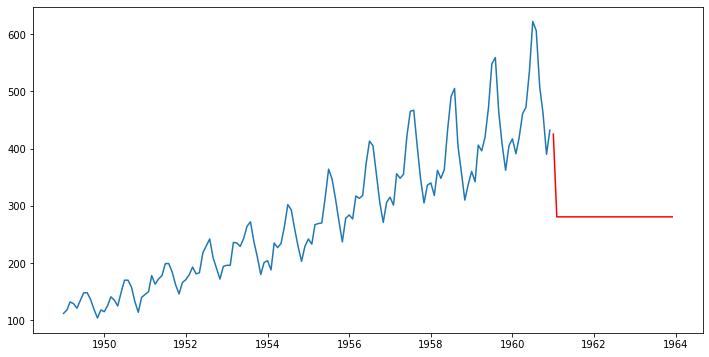

In [ ]:
#Đồ thị dự báo
plt.figure(figsize=(12,6))
plt.plot(data)
plt.plot(forecast, color='r')

plt.show()